In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
# Transforms for MNIST
mnist_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Transforms for CIFAR-10
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [4]:
# MNIST dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)

# CIFAR-10 dataset
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=cifar_transform, download=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 91645493.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25421971.42it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24106421.96it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10542627.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 170498071/170498071 [00:01<00:00, 104602882.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:


# Hyperparameters
input_channels = {'mnist': 1, 'cifar': 3}
num_classes = 10
conv1_out_channels = 16
conv1_kernel_size = 5
conv1_padding = 2
pool_kernel_size = 2
pool_stride = 2
conv2_out_channels = 32
conv2_kernel_size = 5
conv2_padding = 2
fc1_out_features = 512
learning_rate = 0.001
batch_size = 100
num_epochs = 10

# Define the ConvNet architecture
class ConvNet(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, conv1_out_channels, kernel_size=conv1_kernel_size, stride=1, padding=conv1_padding),
            nn.BatchNorm2d(conv1_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=conv2_kernel_size, stride=1, padding=conv2_padding),
            nn.BatchNorm2d(conv2_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        )
        self.fc = nn.Linear(8 * 8 * conv2_out_channels, fc1_out_features)  # CIFAR: 8x8, MNIST: 7x7
        self.output = nn.Linear(fc1_out_features, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.output(x)
        return x


# Choose the dataset (MNIST or CIFAR-10)
dataset = 'mnist'  # Change this to 'cifar' for CIFAR-10 dataset
train_dataset = mnist_train if dataset == 'mnist' else cifar_train
test_dataset = mnist_test if dataset == 'mnist' else cifar_test

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the ConvNet and train the model
model = ConvNet(input_channels=input_channels[dataset], num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# Train the model
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

In [7]:


# Test the model
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the model on the {total} test images: {100 * correct / total:.2f}%')



In [8]:
def create_and_train(optimizer_name):
    model = ConvNet(input_channels=input_channels[dataset], num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Invalid optimizer name")

    print(f"Training with {optimizer_name.upper()} optimizer")
    train(model, train_loader, criterion, optimizer, num_epochs)
    test(model, test_loader)


optimizers = ['sgd', 'adam', 'adagrad']

for optimizer_name in optimizers:
    create_and_train(optimizer_name)

#This will train and test the model using each optimizer (SGD, Adam, and Adagrad) in sequence. After running the code, compare the performance (accuracy) of each optimizer on the test dataset. Note that you might need to adjust the learning rates for each optimizer to get optimal performance.


Training with SGD optimizer
Epoch [1/10], Step [100/600], Loss: 0.3728
Epoch [1/10], Step [200/600], Loss: 0.2386
Epoch [1/10], Step [300/600], Loss: 0.2238


KeyboardInterrupt: ignored

In [ ]:
class ConvNetFewerLayers(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ConvNetFewerLayers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(16 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ConvNetMoreLayers(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ConvNetMoreLayers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(4 * 4 * 64, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


The three optimizers I provided in the example are Stochastic Gradient Descent (SGD), Adaptive Moment Estimation (Adam), and Adaptive Gradient Algorithm (Adagrad). They are different optimization algorithms used to update the model parameters during training. Let's discuss each one briefly:

    Stochastic Gradient Descent (SGD): SGD is a simple yet effective optimization algorithm that updates model parameters by minimizing the objective function (usually the loss function) using gradient information. In each iteration, a random mini-batch of training samples is selected, and the gradients are computed with respect to the mini-batch. The model parameters are then updated using a learning rate and the computed gradients. The primary disadvantage of SGD is that it may require manual tuning of the learning rate, and it may converge slower than other optimizers.

    Adaptive Moment Estimation (Adam): Adam is an adaptive learning rate optimization algorithm that combines the advantages of two other optimization algorithms, Adaptive Gradient Algorithm (Adagrad) and Root Mean Square Propagation (RMSProp). Adam computes individual adaptive learning rates for different parameters by estimating the first and second moments of the gradients. This allows Adam to handle sparse gradients and adapt the learning rate for each parameter during training. In general, Adam converges faster than SGD and requires less manual tuning of the learning rate.

    Adaptive Gradient Algorithm (Adagrad): Adagrad is an optimization algorithm that adapts the learning rate for each parameter during training. It maintains a per-parameter learning rate that is adjusted based on the accumulation of the squared gradients for each parameter. Adagrad can handle sparse gradients and is particularly suited for problems with infrequent or noisy updates to certain parameters. However, the accumulation of squared gradients can cause the effective learning rate to decrease to very small values, resulting in slow convergence or getting stuck in local minima.

In summary, each optimizer has its advantages and disadvantages. SGD is simple and widely used but may require more tuning of the learning rate and converge slower. Adam is an adaptive learning rate optimizer that combines the advantages of Adagrad and RMSProp, converging faster and requiring less manual tuning. Adagrad adapts the learning rate for each parameter based on the accumulation of squared gradients but may suffer from slow convergence due to the decrease in the effective learning rate. The choice of optimizer depends on the problem, model architecture, and dataset characteristics. It's a good practice to experiment with different optimizers to find the one that works best for a given task.


To compare the three optimizers mathematically, let's take a look at their update equations:

    Stochastic Gradient Descent (SGD):
        Update equation:
        θ_t = θ_(t-1) - η * ∇J(θ_(t-1))
    where:
        θ_t represents the model parameters at time step t
        θ_(t-1) represents the model parameters at the previous time step t-1
        η is the learning rate
        ∇J(θ_(t-1)) is the gradient of the objective function (e.g., loss function) with respect to the model parameters θ_(t-1)

Adaptive Moment Estimation (Adam):

    Update equations:
    m_t = β1 * m_(t-1) + (1 - β1) * ∇J(θ_(t-1))
    v_t = β2 * v_(t-1) + (1 - β2) * (∇J(θ_(t-1)))^2
    m_t_hat = m_t / (1 - β1^t)
    v_t_hat = v_t / (1 - β2^t)
    θ_t = θ_(t-1) - η * m_t_hat / (sqrt(v_t_hat) + ε)
    where:
        m_t and v_t are estimates of the first and second moments of the gradients, respectively
        β1 and β2 are the exponential decay rates for the first and second moment estimates, respectively (commonly set to 0.9 and 0.999)
        m_t_hat and v_t_hat are the bias-corrected first and second moment estimates, respectively
        ε is a small constant to prevent division by zero (usually around 1e-8)

Adaptive Gradient Algorithm (Adagrad):

    Update equation:
    G_t = G_(t-1) + (∇J(θ_(t-1)))^2
    θ_t = θ_(t-1) - η * ∇J(θ_(t-1)) / (sqrt(G_t) + ε)
        where:
            G_t is the accumulation of squared gradients up to time step t
            ε is a small constant to prevent division by zero (usually around 1e-8)

From the mathematical update equations, we can see the differences between the optimizers:

    SGD has a fixed learning rate η that is applied uniformly to all model parameters.
    Adam computes adaptive learning rates for each parameter by estimating the first and second moments of the gradients, resulting in faster convergence and less need for manual tuning of the learning rate.
    Adagrad maintains a per-parameter learning rate that is adjusted based on the accumulation of squared gradients, which can handle sparse gradients but may suffer from slow convergence due to the decrease in the effective learning rate.



In [ ]:
import matplotlib.pyplot as plt

# Plot training losses
plt.figure(figsize=(12, 6))
for key, (losses, _) in results.items():
    plt.plot(losses, label=key)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training accuracies
plt.figure(figsize=(12, 6))
for key, (_, accuracies) in results.items():
    plt.plot(accuracies, label=key)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


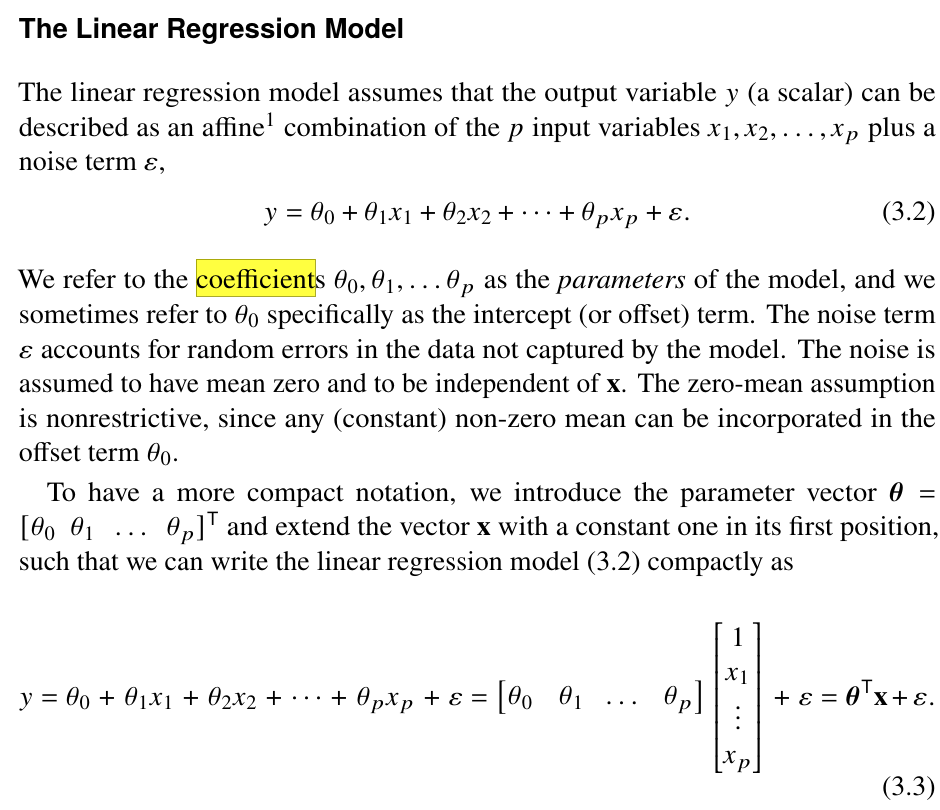

The noise term is often referred to as an irreducible error or an aleatoric uncertainty in the prediction.

Loss function and cost functions page 40 of Lindholm book.
A principled way to define the learning problem is to introduce a loss funtion L(y^, y) which measures how close the model's prediction y^ is to the observed data y. If the model fits the data well, so that y^ approximates y, then the loss function should take a small value and vice versa. Based on the chosen loss function, we also define the cost function as the average loss over the training data. Training a model then amounts to finding the parameter values that minimise the cost. To emphasise that the prediction depends on the parameter theta, we have included theta as an argument to ^y for clarity. The operator argmin_theta means 'the value of theta for which the cost funtion attains it minimum'. The relationship between loss and cost functions is general for all cost functions in the book.


Regularisation (5.3,page 109) is a useful tool for avoiding overfitting if the model was too flexible, such as a polynomial of high degree.  The idea of regularisation in a parametric model is to keep the predicted parameters theta small unless the data really convinces us otherwise, or alternatively if a model with a small value of the predicted parameters theta fits the data almost as well as a model with larger parameter values, the one with small parameters values should be preferred. There are, however, many different ways to implement this idea, and we distinguish between explicit regularisation and implicit regularisation. We will first discuss regularisation, which amounts to modifying the cost function, and in particular so-call L2 and L1 regularisation. The regularisation parameter lambda has to be chosen by the user and has a similar mean: lambda=0 gives the ordinary least squares solution and lambda to infinite gives ^theta=0. Between these extremes, however, L1 and L2 tend to give different solutions. Whereas L2 regularisation pushes all parameters towards small values (but not necessarily exactly zero), L1 tends to favour so-called sparse solutions, where only a few of the parameters are non-zero, and the rest are exactly zero. L1 regularisation can effectively switch off some inputs (by setting the corresponding parameter theta_k to zero), and it can therefore be used as an input (or feature) selection method.

5.4 Parameter Optimisation
Optimisation is about finding the minimum or maximum ob an objective function. Since the maximisatioin problem can formulated as minimisation of the negative objective funtion, we can limit ourselves to minimisation without any loss of generality. There are primarily two ways in which optimisation is used in machine learning:
1. For training a model by minimising the cost function with respect to the model parameters theta θ. In this case, this objective function corresponds to the cost function J(θ), and the optimisation variables correspond to the model parameters.
2. For tuning hyperparameters, such as the regularisation parameter λ. For
instance, by using a held-out validation dataset (see Chapter 4), we can select
λ to minimise the hold-out validation error E hold-out. In this case, the objective function is the validation error, and the optimisation variables correspond to the hyperparameters.

Stochastic Gradient Descent (page 124): with very large n, we can expect the gradient computed only for the first half of the dataset to be almost identical to the gradient based on the second half of the dataset. Consequently, it might be a waste of time to compute the gradient based on the whole training dataset at each iteration of gradient descent. Instead, we could compute the gradient based on the first half of the training dataset, update the parameters according to the gradient descent method Algorithm5.1, and then compute the gradient dor the new parameters based on the second half of the training data. In other words, we use only a subsample of the training data when we compute the gradient. In this way, we still make use of all the training data, but it is split into two consecutive  parameter updates. We can extend on this idea and consider subsampling with even fewer data points used in each gradient computation. The extreme version of subsampling would be to use only onse single data point each time we compute the gradient. In practice it is most common to do smt in between . We call a small subsample of data a mini-batch, which typically can contain n_b=10, n_b=100, n_b=1000 data points. One complete pass through the training data is called an epoch, and consequently consists of n/n_b iterations. When using mini-batches it is important to ensure that the different mini-batches are balanced and representative for the whole dataset. For example, if we have a big training dataset with a few different output classes, and the dataset is sorted with respect to the output, the mini-batch with the first nb data points would only include one class and hence not give a good approximation of the gradient for the full dataset. For this reason, the mini-batches should be formed randomly. One implementation of this is to first randomly shuffle the training data, and thereafter divide it into mini-batches in an ordered manner. When we have completed one epoch, we do another random reshuffling of the training data and do another pass through the dataset. We summarise gradient descent with mini-batches, often called stochastic gradient descent, as Algorithm 5.3.
Chapter 6, some commonly used methods include automatic adaption of the learning rate and an idea called momentum to counteract the randomness caused by subsampling. The AdaGrad (short for adaptive gradient), RMSProp (short for root mean square propagation), and Adam (short for adaptive moments) methods are such examples. For logistic regession in the `big data' setting, the Stochastic Average Gradient (SAG) method, which averages over all previous gradient estimates, has proven useful, to mention but a few.

SGD converses if the learning rate is wisely chosen and constant, since the gradient itself is zero at the minimum. For SGD, on the other hand, we can not obtain convergence with a onstant learning rate. The reason is that we only use an estimate of the true gradient and this estimate will not necessarily be zero at the minimum othe objective function, but there might still be a considerable amount  of noise in the gradient estimate due to the subsampling. As a consequence, the SGD algorithm with a constant learning rate will not converge towards a point but will continue to wander around, somewhat randomly. For the algorithm to work properly, we also need the gradient estimate to be unbiased. The intuitive reason is that the unbiased gradient ensures that the algorithm will on average step in the right direction in its search for the optimum.